# 2D Finite-difference simulation of fault-zone trapped waves
_Computational Seismology, Igel (2016)_ <br>
Exercise 4.29

_Write a computer program for the 2D acoustic wave equation following the equations presented in this chapter. Implement the analytical
solution (see Chapter 2) and try to match it with appropriate parameters._

<br>
<strong>Scenario: Fault-zone trapped waves (p. 92)</strong><br>
<br>"Let us investigate the effects of a narrow 200 m-wide fault zone with a 25% velocity decrease. In accordance with observations the target frequency is 10 Hz (dominant, maximum 30 Hz). We expect that for a seismometer sitting at the top of the fault zone a seismogram length of tmax = 3.5 s will be sufficient to observe trapped waves. <br>
<br>
Note that the scalar acoustic wave equation is mathematically identical to the SH-wave-propagation problem (assuming constant density). So, in the case of fault-zone trapped waves that are predominantly observed for SH-type ground motions, this is a useful basic physical model." <br>

<br>
<strong>2D acoustic wave equation:</strong>
$$\partial_t^2 p(x, z, t) = c(x, z)^2 (\partial^2_x p(x, z, t) \partial^2_z p(x, z, t)) + s(x, z,t)$$

We can calculate a solution by iterating over the time elements:
$$p(t+dt) = 2p(t) - p(t-dt) + dt^2[c^2\partial^2_xp + s],$$ where the 3-point operators are
$$d^2_xp(x,z) = \frac{p(x+dx) - 2p(x) + p(x-dx)}{dx^2}$$
$$d^2_zp(x,z) = \frac{p(z+dz) - 2p(z) + p(z-dz)}{dz^2},$$ meaning we also need to iterate over x and z.


We'll use the derivative of a Gaussian as our source time function (so that our resulting waveform is a Gaussian):
$$s(t) = -8f_0(t-t_0)e^{-(f_0(t-t_0))^2}$$

<br>
Meanwhile, the <strong>analytical solution</strong> is
$$p(t) = G(t) * s(t),$$
where 
$$G(t) =
\begin{cases}
    \begin{align}    
        0,                                      &\quad t \lt \frac{|x|}{c} \\
        \frac{1}{2c \sqrt{t^2-\frac{r^2}{c^2}}}, &\quad t \ge \frac{|x|}{c}
    \end{align}
\end{cases}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xmax = 5            # spatial range (km)
zmax = 5
dx = .01            # distance between grid points (km)
dz = dx
nx = int(xmax/dx)   # number of grid points
nz = int(zmax/dz)
    
tmax = 1            # length of seismogram (s)
dt = .001           # time interval (s)
nt = int(tmax/dt)   # number of time steps
    
xsrc = 0
zsrc = 0            # z-coord. of source
xrec = 1            # x-coord. of receiver
zrec = 1.5          # z-coord. of source
f0 = 20             # dominant frequency (Hz)
t0 = .3             # time shift (s)
tsnap = .5          # time snapshot is taken (s)

x = np.arange(-xmax/2, xmax/2, dx)   # space
z = np.arange(-zmax/2, zmax/2, dz)
t = np.arange(0, tmax, dt)           # time

c = np.where(((x <= .1) & (x >= -.1)), 2.25, 3.00)    # piecewise wavefield velocity (km/s)
ind = np.linspace(0, len(c) - 1, nt, dtype=int)       # resize c from size nx to nt
c = c[ind]

# get indices of source & receiver locations (will be used to add source term/make seis in algorithm)
ixsrc, ixrec = round(((xsrc+xmax/2)/xmax)*len(x)), round(((xrec+xmax/2)/xmax)*len(x))
izsrc, izrec = round(((zsrc+zmax/2)/zmax)*len(z)), round(((zrec+zmax/2)/zmax)*len(z))

# CFL criterion check
eps = max(c)*dt/dx
if eps > 1/np.sqrt(3):
    raise ValueError('Error: CFL criterion not satisfied! Ensure that c*dt/dx <= 1.')

print('# grid points in x:', nx, '\n# grid points in z:', nz, '\n# grid points in time:', nt)


# grid points in x: 500 
# grid points in z: 500 
# grid points in time: 1000


#### Source time function

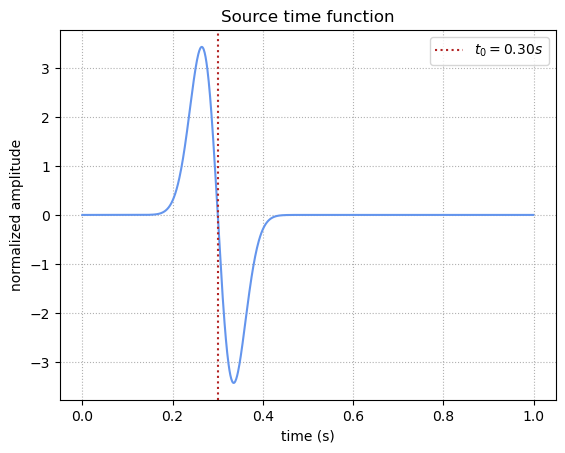

In [3]:
src = -8*f0*(t-t0)*np.exp(  -((t - t0)*f0)**2   )

plt.plot(t, src, 'cornflowerblue')
plt.axvline(t0, linestyle = ':', color = 'firebrick', label = '$t_0 = {:.2f} s$'.format(t0))
plt.xlabel('time (s)')
plt.ylabel('normalized amplitude')
plt.title('Source time function')
plt.legend()
plt.grid(linestyle = ':')

#### Finite-difference calculations

In [4]:
p = np.zeros((nx, nz), dtype = np.float64) 
pold = np.zeros((nx, nz), dtype = np.float64)   # p(t-dt)
pnew = np.zeros((nx, nz), dtype = np.float64)   # p(d+dt)
dx2p = np.zeros((nx, nz), dtype = np.float64)   # 2nd derivative in space
dz2p = np.zeros((nx, nz), dtype = np.float64)   # 2nd derivative in space
seis = np.zeros(nt)

for it in range(nt):   

    # calculate partial derivatives
    for ix in range(1, nx - 1):
        dx2p[ix, :] = (p[ix + 1, :] - 2 * p[ix, :] + p[ix - 1, :]) / dx**2
            
    for iz in range(1, nz - 1):
        dz2p[:, iz] = (p[:, iz + 1] - 2 * p[:, iz] + p[:, iz - 1]) / dz**2

    # time extrapolation
    pnew = 2 * p - pold + c[it]**2 * dt**2 * (dx2p + dz2p)
 
    # add source term at (ixsrc, izsrc)
    pnew[ixsrc, izsrc] = pnew[ixsrc, izsrc] + dt**2 * src[it] / np.sqrt(dx**2 + dz**2)

    # remap time levels
    pold = p
    p = pnew
    
    # make seismogram
    seis[it] = p[ixrec, izrec]

#### Compare with analytical solution

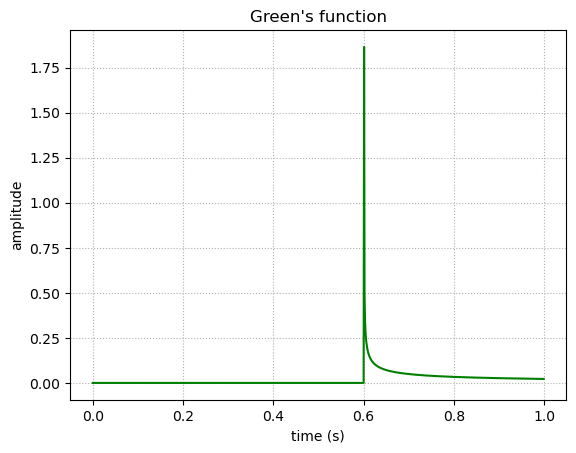

In [5]:
# Green's function:
G = np.zeros(len(t))
r = np.sqrt( (x[ixsrc]-x[ixrec])**2 + (z[izsrc]-z[izrec])**2 )

for it in range(nt):
    if (t[it] - r / c[it]) >= 0:
        G[it] = 1 / ( 2*np.pi*c[it]**2 * np.sqrt(np.abs(t[it]**2 - (r**2)/c[it]**2)) )

plt.plot(t, G, 'g')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Green\'s function')
plt.grid(linestyle = ':')

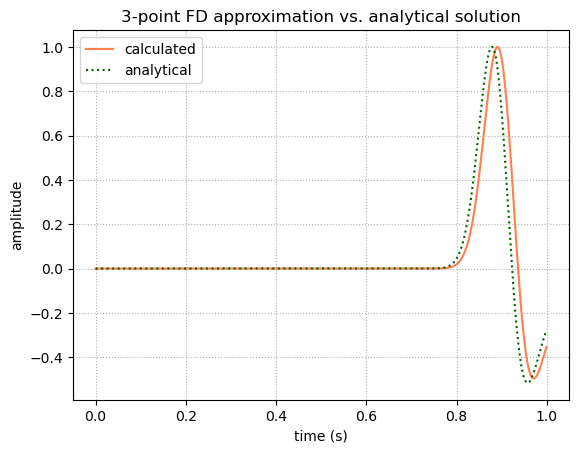

In [6]:
# analytical seismogram:
seis_a = np.convolve(G, src * dt)[:nt]

# plot to show comparison:
plt.plot(t[:nt], seis/max(seis), 'coral', label = 'calculated')
plt.plot(t[:nt], seis_a/max(seis_a), 'darkgreen', linestyle = ':', label = 'analytical')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('3-point FD approximation vs. analytical solution')
plt.legend()
plt.grid(linestyle = ':')